En este archivo puedes escribir lo que estimes conveniente. Te recomendamos detallar tu solución y todas las suposiciones que estás considerando. Aquí puedes ejecutar las funciones que definiste en los otros archivos de la carpeta src, medir el tiempo, memoria, etc.

Load common libraries and file path

In [1]:
file_path = "../farmers-protest-tweets-2021-2-4.json"
import matplotlib.pyplot as plt
import memory_profiler
from cProfile import Profile
from pstats import Stats, SortKey

def plot(x_values, y_values, x_label, y_label, title=''):
    plt.plot(x_values, y_values, marker='o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

For the first exercise q1_memory,  I've implemented two approaches.  Lets run them in two different cells and decide what is the best


<h5>1. First Approach:</h5>
- Retrieve the top 10 dates. </br>
- Filter users who posted on those days. </br>
- For each day, identify the top user who posted on that day. </br>
Based on the results, this approach proves superior as it exclusively fetches the required dates while disregarding the remainder. 

In [ ]:
from q1_memory import q1_memory
%load_ext memory_profiler
%mprun -f q1_memory_v2 q1_memory(file_path)

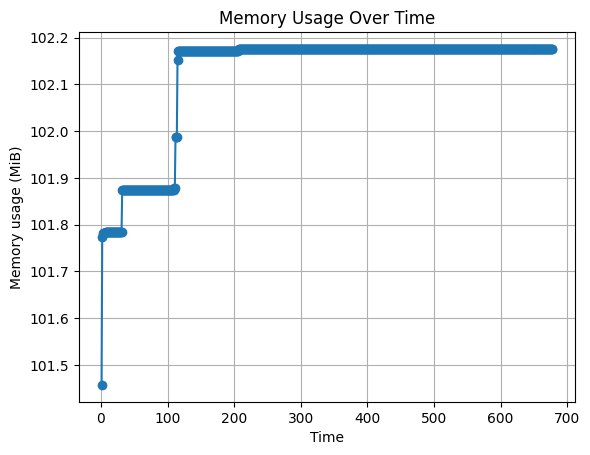

In [2]:
from q1_memory import q1_memory
memory_usage = memory_profiler.memory_usage((q1_memory, (), {'file_path': file_path}))
x_values = list(range(1, len(memory_usage) + 1))  
# Plot the memory usage over time
plot(x_values, memory_usage, 'Interval', 'Memory usage (MiB)', 'Memory Usage Over Time')

<h5>2. Second approach</h5>
- Get a list with all tuples (date, username)
- Get top 10 of posted dates
- Get top 1 user who posted in each day

In [ ]:
from typing import List, Tuple
from datetime import datetime
import json
from collections import Counter

def q1_memory_v2(file_path: str) -> List[Tuple[datetime.date, str]]:
    #Due to I need to minimize memory space, generator is a good approach
    def read_json():
        with open(file_path, 'r') as file:
            while line := file.readline():
                yield json.loads(line)

    items = read_json()
    date_user = []
    #get date and user for every item and append to a list
    for item in items:
        only_date = datetime.strptime(item['date'], "%Y-%m-%dT%H:%M:%S%z").date()
        date_user.append((only_date, item['user']['username']))

    #get the top 10 dates
    date_counts = Counter(date for date, _ in date_user).most_common(10)
    dates = [d for d, _ in date_counts]
    del date_counts
    result = []
    # for each top date get the top user. Append to the final result the date and user
    for d in dates:
        user_by_date = Counter(user for date, user in date_user if date == d).most_common(1)
        result.append((d, user_by_date[0][0]))

    return result

memory_usage = memory_profiler.memory_usage((q1_memory_v2, (), {'file_path': file_path}))
x_values = list(range(1, len(memory_usage) + 1))  
# Plot the memory usage over time
plot(x_values, memory_usage, 'Interval', 'Memory usage (MiB)', 'Memory Usage Over Time')

As a conclusion, the <b>First approach</b> is the optimal approach

<h4>Exercise 1 Time performance:</h4> 
This time, I've opted to utilize <b>Pandas</b> due to its utilization of <b>NumPy</b> under the hood. The NumPy library, partially written in C, significantly enhances performance compared to native Python, often by orders of magnitude.
The following cell employs cProfile and pstats to execute q1_time and measure its execution time. I've chosen to display only the 15 functions with the longest execution times.

In [ ]:
from q1_time import q1_time

with Profile() as profile:
    print(q1_time(file_path))
    (
     Stats(profile)
     .strip_dirs()
     .sort_stats(SortKey.TIME)
     .print_stats(15)
    )

<h4>Exercise 2: Memory problem </h4>
To solve this exercise I've decided to use to external libraries emoji and regex. The last allows to find grapheme clusters occurrences

In [ ]:
from q2_memory import q2_memory
%reload_ext memory_profiler
%mprun -f q2_memory q2_memory(file_path)

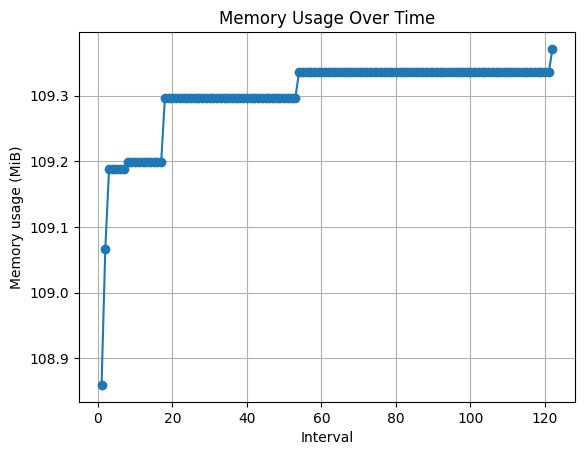

In [2]:
from q2_memory import q2_memory
memory_usage = memory_profiler.memory_usage((q2_memory, (), {'file_path': file_path}))
x_values = list(range(1, len(memory_usage) + 1))  
# Plot the memory usage over time
plot(x_values, memory_usage, 'Interval' ,'Memory usage (MiB)', 'Memory Usage Over Time')

<h4>Exercise 2: Time problem. </h4> 
Let see which approach is faster to load the file


In [ ]:
import pandas as pd
with Profile() as profile:
    df = pd.read_json(file_path, lines=True)
    print(df.head())
    (
     Stats(profile)
     .strip_dirs()
     .sort_stats(SortKey.TIME)
     .print_stats(15)
    )

Now let use readlines to process the file with native Python

In [ ]:
import json

with Profile() as profile:
    file = open(file_path, 'r')
    data = json.loads(f"[{','.join(file.readlines())}]")
    (
     Stats(profile)
     .strip_dirs()
     .sort_stats(SortKey.TIME)
     .print_stats(15)
    )

As a conclusion for the file load time there is no difference

A first approach that I've tried to use was with Pandas. But this solution is suboptimal compared with the implemented in q2_time similar to q2_memory but loading the complete file instead to use generator

In [6]:
from typing import List, Tuple
import pandas as pd
import emoji
import regex

#Subotpimal solution
def q2_time_v2(file_path: str) -> List[Tuple[str, int]]:
    df = pd.read_json(file_path, lines=True)
    # Get a list of emojis in a given text
    df['emojis'] = df['renderedContent'].apply(
                                lambda x: [c for c in regex.findall(r'\X', x) if emoji.is_emoji(c)])

    #df = df.loc[:, ~df.columns.isin(['emojis'])]
    # I need to explode that emoji list
    exploded_df = df.explode('emojis')
    # Count emojis occurrence
    exploded_df = exploded_df.groupby('emojis').size().reset_index(name='count_emojis')
    # Keep the top 10 used emojis
    exploded_df = exploded_df.nlargest(n=10, columns='count_emojis', keep='all')

    return list(exploded_df[['emojis', 'count_emojis']].to_records(index=False))
    
with Profile() as profile:
    print(q2_time_v2(file_path))
    (
     Stats(profile)
     .strip_dirs()
     .sort_stats(SortKey.TIME)
     .print_stats(15)
    )


[('🙏', 5049), ('😂', 3072), ('🚜', 2972), ('🌾', 2182), ('🇮🇳', 2086), ('🤣', 1668), ('✊', 1642), ('❤️', 1382), ('🙏🏻', 1317), ('💚', 1040)]
         19601210 function calls (19600230 primitive calls) in 22.638 seconds

   Ordered by: internal time
   List reduced from 1025 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.387    5.387    5.436    5.436 {built-in method pandas._libs.json.ujson_loads}
   117407    5.342    0.000    5.342    0.000 {method 'findall' of '_regex.Pattern' objects}
   117407    3.400    0.000    6.261    0.000 1508000583.py:11(<listcomp>)
 16364431    2.861    0.000    2.861    0.000 core.py:316(is_emoji)
        1    0.501    0.501    0.786    0.786 {method 'read' of '_io.TextIOWrapper' objects}
   117407    0.473    0.000    1.616    0.000 regex.py:449(_compile)
       22    0.438    0.020    0.438    0.020 {method 'split' of 'str' objects}
   234820    0.335    0.000    0.794    0.000 enum.py:986

This solution improves the execution time compared with the use of pandas

In [3]:
from q2_time import q2_time

with Profile() as profile:
    print(q2_time(file_path))
    (
     Stats(profile)
     .strip_dirs()
     .sort_stats(SortKey.TIME)
     .print_stats(15)
    )

[('🙏', 5049), ('😂', 3072), ('🚜', 2972), ('🌾', 2182), ('🇮🇳', 2086), ('🤣', 1668), ('✊', 1642), ('❤️', 1382), ('🙏🏻', 1317), ('💚', 1040)]
         19167234 function calls (19167230 primitive calls) in 21.526 seconds

   Ordered by: internal time
   List reduced from 117 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   117407    6.195    0.000    6.195    0.000 {method 'findall' of '_regex.Pattern' objects}
        1    4.404    4.404    4.445    4.445 decoder.py:343(raw_decode)
   117407    3.988    0.000    7.419    0.000 q2_time.py:22(<dictcomp>)
 16364431    3.295    0.000    3.295    0.000 core.py:316(is_emoji)
        1    0.712    0.712    0.823    0.823 {method 'readlines' of '_io._IOBase' objects}
   117407    0.501    0.000    1.765    0.000 regex.py:449(_compile)
   234824    0.377    0.000    0.901    0.000 enum.py:986(__and__)
        1    0.302    0.302   21.526   21.526 q2_time.py:6(q2_time)
        1    0.244    0.244 

<h4>Exercise 3: Top 10 influencer users </h4>
I'll use the library jsonpath-ng in order to make easy get all username values from <b>$.mentionedUsers[*].username</b>

<h5>1. Memory Solution:</h5>
I.  Read line by line using iterator, but returns the list of mentioned users in the tweet</br>
II. Sum new occurrences to the previous result 


In [ ]:
from q3_memory import q3_memory
%reload_ext memory_profiler
%mprun -f q3_memory q3_memory(file_path)

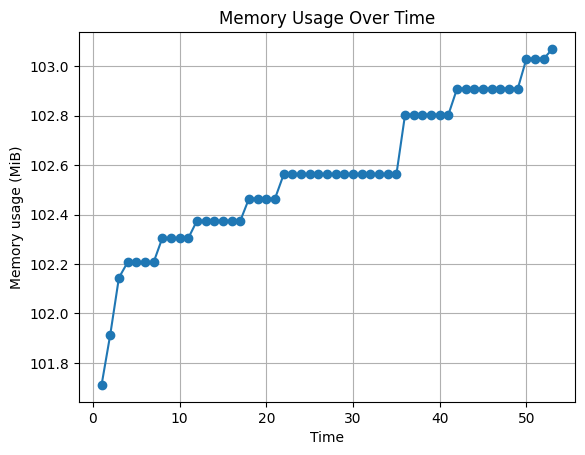

In [2]:
from q3_memory import q3_memory
memory_usage = memory_profiler.memory_usage((q3_memory, (), {'file_path': file_path}))
x_values = list(range(1, len(memory_usage) + 1))  
# Plot the memory usage over time
plot(x_values, memory_usage, 'Time' ,'Memory usage (MiB)', 'Memory Usage Over Time')

Lets check time using <b>orjson</b>

In [5]:
import orjson

def read_json():
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data_json = '[' + ','.join(lines) + ']'
        return orjson.loads(data_json)

        
def run_exec():
    items = read_json()
    
with Profile() as profile:
    run_exec()
    (
    Stats(profile).strip_dirs().sort_stats(SortKey.TIME).print_stats(15)
    )

         133981 function calls in 6.799 seconds

   Ordered by: internal time
   List reduced from 27 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    4.242    4.242    4.292    4.292 {orjson.loads}
        1    1.408    1.408    1.702    1.702 {method 'readlines' of '_io._IOBase' objects}
        1    0.450    0.450    6.769    6.769 1448397613.py:3(read_json)
        1    0.325    0.325    0.325    0.325 {method 'join' of 'str' objects}
    49772    0.197    0.000    0.197    0.000 {built-in method _codecs.utf_8_decode}
    49772    0.096    0.000    0.293    0.000 codecs.py:319(decode)
        1    0.030    0.030    6.799    6.799 1448397613.py:10(run_exec)
     3278    0.020    0.000    0.050    0.000 ipkernel.py:775(_clean_thread_parent_frames)
     1639    0.011    0.000    0.013    0.000 threading.py:1478(enumerate)
     1639    0.009    0.000    0.015    0.000 ipkernel.py:790(<setcomp>)
    13112    0.007    0.0

In [4]:
from q3_memory import q3_memory

with Profile() as profile:
    print(q3_memory(file_path))
    (
     Stats(profile)
     .strip_dirs()
     .sort_stats(SortKey.TIME)
     .print_stats(15)
     .dump_stats('q3_memory_time_measure.prof')
    )

[('narendramodi', 2265), ('Kisanektamorcha', 1840), ('RakeshTikaitBKU', 1644), ('PMOIndia', 1427), ('RahulGandhi', 1146), ('GretaThunberg', 1048), ('RaviSinghKA', 1019), ('rihanna', 986), ('UNHumanRights', 962), ('meenaharris', 926)]
         6653029 function calls (6535443 primitive calls) in 9.878 seconds

   Ordered by: internal time
   List reduced from 283 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   117407    3.861    0.000    3.861    0.000 decoder.py:343(raw_decode)
   117408    1.006    0.000    1.210    0.000 {method 'readline' of '_io.TextIOWrapper' objects}
   117408    0.677    0.000    9.523    0.000 q3_memory.py:14(read_json)
   220810    0.417    0.000    1.698    0.000 jsonpath.py:585(_find_base)
   220810    0.399    0.000    0.768    0.000 jsonpath.py:554(get_field_datum)
   441620    0.322    0.000    0.464    0.000 jsonpath.py:102(__init__)
   117407    0.307    0.000    4.401    0.000 decoder.py:332(deco

In [7]:
from q3_time import q3_time

with Profile() as profile:
    print(q3_time(file_path))
    (
     Stats(profile)
     .strip_dirs()
     .sort_stats(SortKey.TIME)
     .print_stats(15)
     .dump_stats('q3_time_time_measure.prof')
    )

[('narendramodi', 2265), ('Kisanektamorcha', 1840), ('RakeshTikaitBKU', 1644), ('PMOIndia', 1427), ('RahulGandhi', 1146), ('GretaThunberg', 1048), ('RaviSinghKA', 1019), ('rihanna', 986), ('UNHumanRights', 962), ('meenaharris', 926)]
         5063740 function calls (5063494 primitive calls) in 26.792 seconds

   Ordered by: internal time
   List reduced from 386 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.599    5.599    5.599    5.599 q3_time.py:21(<listcomp>)
   441621    3.955    0.000    4.787    0.000 jsonpath.py:102(__init__)
        1    3.284    3.284    3.393    3.393 {orjson.loads}
        4    2.404    0.601   15.999    4.000 jsonpath.py:267(<listcomp>)
   220810    2.150    0.000    9.368    0.000 jsonpath.py:585(_find_base)
   220810    1.489    0.000    4.891    0.000 jsonpath.py:554(get_field_datum)
   779838    1.354    0.000    1.428    0.000 jsonpath.py:95(wrap)
   220810    1.001    0.000    5.

<h4>Exercise 3 Time and Memory Analysis</h4>
<h5>Memory Analysis</h5>
Both Files q3_memory.py and q3_time.py imports `memory_profiler` in order to check the consumed memory. If you want to see how much memory use each one, follow these steps: (eg. q3_memory.py)</br>
1. Uncomment these lines at the end of the file </br>
```python 
# path = '../resources/farmers-protest-tweets-2021-2-4.json'
# q3_memory(path)
```
2. From the terminal run this `$ mprof run python q3_memory.py`
3. This will generate a file called `q3_memory.log` in which you can see the evolution of memory usage

</br></br>
<h5>Time Analysis</h5>
For time Analysis I've decided to use cProfile, Stats along side with Tuna package (to plot). As you can see in The last two previous cells, there are `dump_stats` which generate two files to see the profiling for each file. </br>
Follow these steps: </br>
1. Run a given cell. This will generate the `.prof` file </br>
2. In a console run `tuna q3_memory_time_measure.prof` This will open the browsert showing the profiling

<h4>AWS CloudFormation</h4>
Finally, if you want to deploy and test in AWS environment follow this steps:
1. Upload the zip file to S3 bucket
2. Edit template.yaml and replace the line `aws s3 cp s3://dea-c01-marcos/data-eng-latam/tweets.json.zip .` with your actual file path in s3. IMPORTANT: upload the zip file
3. Do the deploy `aws cloudformation deploy --stack-name comandrunner-data-eng-challenge --template-file ./template.yaml` </br>
This cloudFormation use AWSUtility::CloudFormation::CommandRunner defined here https://github.com/aws-cloudformation/aws-cloudformation-resource-providers-awsutilities-commandrunner which allows execute bash commands in EC2.</br>
This deploy will run the commands detailed in <b>RunCommand</b> which will run `python app.py` which is also in the root and will get the stats for both Memory consuming and time executing 